In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from shGLM_class import shGLM
from sklearn import metrics

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
syn_T = 351
C_den = torch.tensor([0,1,1,1,1])
sub_no = C_den.shape[0]

batch_size = 2094

syn_basis_no = 3
hist_basis_no = 3
spike_status = False
hist_T = 251

In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
N = torch.sum(Ensyn) + torch.sum(Insyn)
print(N)

C_syn = torch.zeros(sub_no, N)
count = 0
for m in range(sub_no):
    for e in range(Ensyn[m]):
        C_syn[m,count] = 1
        count += 1
        
for m in range(sub_no):
    for i in range(Insyn[m]):
        C_syn[m,count] = -1
        count += 1

tensor(749)


# Adjust W and C

In [4]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")[:train_T]
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")[:train_T]
neural = np.hstack((E_neural, I_neural))

In [5]:
Delta_init = np.exp(4.7492)
K_syn_init = np.tile(np.asarray([[ 0.0506, -0.0364],
                                 [-0.1064,  0.0716],
                                 [ 0.0970, -0.0528]]).reshape((1,-1,2)),
                                 (sub_no, 1, 1))
syn_basis_tau = np.asarray([1.5266, 2.2565, 2.7229])
C_init = np.exp(3.1747)
sigma_init = 0.5

new_Theta = np.empty((sub_no))
new_C = np.ones((sub_no)) * C_init
#new_K_syn = np.empty_like(K_syn_init)
new_K_syn = K_syn_init
new_K_syn[0] *= 1

window = np.arange(syn_T) - Delta_init
window[window < 0] = 0

filt_neural = np.empty((neural.shape[0], sub_no))
# filt_neural contains just the filtered synpatic inputs to each subunit
upstream_out = np.empty((neural.shape[0], sub_no))
# upstream_out contains all the inputs summed, nonlin'ed, but NOT C

In [6]:
for s in range(sub_no):
    sub_out = np.zeros((neural.shape[0]))
    e_idx = torch.where(C_syn[s] == 1)[0].numpy()
    i_idx = torch.where(C_syn[s] == -1)[0].numpy()
    
    in_e = neural[:,e_idx]
    in_i = neural[:,i_idx]
    
    kern_e = np.zeros((syn_T))
    kern_i = np.zeros((syn_T))
    for b in range(K_syn_init.shape[1]):
        tau = np.exp(syn_basis_tau[b])
        t_tau = window / tau
        kern_e += np.multiply(t_tau, np.exp(-t_tau)) * K_syn_init[s,b,0]
        kern_i += np.multiply(t_tau, np.exp(-t_tau)) * K_syn_init[s,b,1]
    
    for i in range(e_idx.shape[0]):
        sub_out += np.convolve(in_e[:,i], np.flip(kern_e), mode="same")
        
    for i in range(i_idx.shape[0]):
        sub_out += np.convolve(in_i[:,i], np.flip(kern_i), mode="same")
        
    filt_neural[:,s] = sub_out

In [7]:
print(np.mean(filt_neural, 0))

[-2.52652313  0.33940629  0.79855397  0.66405771  0.26167052]


In [8]:
for s in range(sub_no):
    subunit = sub_no - 1 - s
    upstream_idx = torch.where(C_den == subunit + 1)[0].numpy()
    if upstream_idx.size == 0:
        upstream_in = np.zeros((neural.shape[0]))
    else:
        upstream_in = upstream_out[:,upstream_idx]
        
    sub_in = filt_neural[:,subunit]
    
    if upstream_idx.size > 0:
        old_sigma = np.std(sub_in + np.sum(upstream_in * new_C[upstream_idx], axis=1))
    else:
        old_sigma = np.std(sub_in)
    sigma_factor = sigma_init / old_sigma
    print(sigma_factor)
    
    if upstream_idx.size > 0:
        new_C[upstream_idx] = new_C[upstream_idx] * sigma_factor
        new_K_syn[subunit,:,:] = K_syn_init[subunit,:,:] * sigma_factor
    else:
        new_K_syn[subunit,:,:] = K_syn_init[subunit,:,:] * sigma_factor
    
    if upstream_idx.size > 0:
        comb_in = sub_in*sigma_factor + np.sum(upstream_in * new_C[upstream_idx], axis=1)
    else:
        comb_in = sub_in * sigma_factor
    new_Theta[subunit] = np.mean(comb_in)
    comb_out = 1 / (1+np.exp(-comb_in + new_Theta[subunit]))
    upstream_out[:,subunit] = comb_out

2.358381342842173
1.3730549339607687
1.4948683510152412
2.0098927017267987
0.07619250196562218


In [9]:
print(new_K_syn)
print(new_C)
print(new_Theta)
print(np.mean(upstream_out, axis=0))
print(np.std(upstream_out, axis=0))

[[[ 0.00385534 -0.00277341]
  [-0.00810688  0.00545538]
  [ 0.00739067 -0.00402296]]

 [[ 0.10170057 -0.07316009]
  [-0.21385258  0.14390832]
  [ 0.19495959 -0.10612233]]

 [[ 0.07564034 -0.05441321]
  [-0.15905399  0.10703257]
  [ 0.14500223 -0.07892905]]

 [[ 0.06947658 -0.0499792 ]
  [-0.14609304  0.09831073]
  [ 0.13318633 -0.0724973 ]]

 [[ 0.1193341  -0.08584508]
  [-0.25093177  0.1688601 ]
  [ 0.22876299 -0.12452253]]]
[23.9196429   1.82249744  1.82249744  1.82249744  1.82249744]
[3.43269426 0.68217023 1.19373305 0.91178772 0.61711887]
[0.4981192  0.49738599 0.49806851 0.49667812 0.49700399]
[0.11721481 0.11547557 0.11551295 0.10995138 0.11244424]


In [10]:
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Delta.npy", np.log(Delta_init))
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Theta.npy", new_Theta)
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_C.npy", np.log(new_C))
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_K_syn.npy", new_K_syn)
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Tau_syn.npy", syn_basis_tau)

# Train ALL Params

In [4]:
fit_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T)


V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
adjust_K_syn = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_K_syn.npy"))
adjust_Delta = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Delta.npy"))
adjust_C = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_C.npy"))
adjust_Theta = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Theta.npy"))
adjust_Tau_syn = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Tau_syn.npy"))

with torch.no_grad():
    fit_shGLM.K_syn = nn.Parameter(adjust_K_syn.float(), requires_grad=True)
    fit_shGLM.Delta = nn.Parameter(adjust_Delta.float().reshape(1), requires_grad=True)
    fit_shGLM.C = nn.Parameter(adjust_C.float(), requires_grad=True)
    fit_shGLM.Theta = nn.Parameter(adjust_Theta.float(), requires_grad=True)
    fit_shGLM.syn_basis_tau = nn.Parameter(adjust_Tau_syn.float(), requires_grad=True)
    
fit_shGLM.train().cuda()

shGLM()

In [6]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

35812
35812


In [8]:
no_spike_bool = True
spike_bool = False

fit_shGLM.V_o.requires_grad = no_spike_bool
fit_shGLM.K_syn.requires_grad = True
fit_shGLM.Delta.requires_grad = no_spike_bool
fit_shGLM.C.requires_grad= no_spike_bool
fit_shGLM.Theta.requires_grad = True

fit_shGLM.thresh.requires_grad = spike_bool
fit_shGLM.spike_size.requires_grad = spike_bool
fit_shGLM.K_hist.requires_grad = spike_bool


In [9]:
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.01)
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.0025)
optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.0005)

In [ ]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_shGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    
    #loss = criterion(batch_ref, batch_pred)
    
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    loss_array[i] = loss.item()
    
    #print(i, train_score)
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        test_pred = fit_shGLM(test_neural.float())
        #test_loss = criterion(test_V_ref, test_pred)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score, train_score)
        if i%500 == 0:
            torch.save(fit_shGLM.state_dict(), "/media/hdd01/sklee/shglm/biophysical/final_fit/final5_nospike_s3_h3_shglm_i"+str(i)+".pt")
    


<ipython-input-10-2d624c771b80>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 2.674507759407976 0.806353805226172 0.5635581741588243
TEST 100 2.3199719820949287 0.8320237641766659 0.711649815347488
TEST 200 2.1849701569965685 0.8417984936060594 0.7005088851160195
TEST 300 2.1893993472214657 0.8414778006385142 0.6641754806018907
TEST 400 2.0781447644719298 0.8495331246455204 0.7794508016102665
TEST 500 2.035647870761 0.8526100877744652 0.6958874113938617
TEST 600 2.023287132518485 0.8535050599110501 0.8171919937783986
TEST 700 1.9943547059351576 0.8555998955940036 0.8315280396349727
TEST 800 1.9600140532933719 0.8580863107776973 0.7574259341375404
TEST 900 2.1048408656652486 0.8476002088132422 0.7211239714415076
TEST 1000 1.9104353220013646 0.8616760302701802 0.6075782513305354
TEST 1100 1.9690257825388755 0.8574338217264377 0.6765253068646189
TEST 1200 1.9091404991204928 0.8617697811849557 0.7368051880508996
TEST 1300 1.9182737037386965 0.8611084967598435 0.7490812767921251
TEST 1400 2.148939335497488 0.8444072844646127 0.6942968199544777
TEST 1500 1.8710

TEST 12400 1.9355539569834268 0.8598573299383653 0.7599058832289203
TEST 12500 1.8559911516082273 0.8656180290819802 0.7936604590534602
TEST 12600 1.8936320056303957 0.8628926647030395 0.8087064152155266
TEST 12700 1.852773396344891 0.8658510087915424 0.7998774087542183
TEST 12800 1.8766277149352 0.8641238506117493 0.7979309962074572
TEST 12900 1.9583463462820765 0.8582070600936604 0.8131089912932652
TEST 13000 1.884450203923759 0.8635574677972755 0.7783368327612081
TEST 13100 1.8942733783629047 0.8628462265134236 0.8144339198181358
TEST 13200 1.865646524024915 0.8649189374205408 0.7230840582678837
TEST 13300 2.121511068805286 0.8463932122618817 0.7547511470068926
TEST 13400 1.8758657573006285 0.8641790196913312 0.807690985970714
TEST 13500 1.8447734645647673 0.866430239249033 0.847947787034464
TEST 13600 1.933068766725931 0.8600372687382323 0.6551748128667383
TEST 13700 1.895301355667756 0.8627717963872406 0.8406048680451862
TEST 13800 2.0574303678164196 0.8510329385937875 0.688834851

In [11]:
for name, param in fit_shGLM.named_parameters():
    print(name, param.data)

V_o tensor([-75.5824], device='cuda:0')
K_syn tensor([[[-0.0028,  0.0454],
         [ 0.0065, -0.0508]],

        [[-0.0807,  0.0594],
         [ 0.1257, -0.0699]],

        [[-0.0740,  0.1284],
         [ 0.1354, -0.1249]],

        [[-0.0528,  0.0972],
         [ 0.1037, -0.1198]],

        [[-0.0635,  0.0678],
         [ 0.1158, -0.1245]]], device='cuda:0')
syn_basis_tau tensor([2.2178, 2.5067], device='cuda:0')
Delta tensor([4.8635], device='cuda:0')
C tensor([3.5296, 0.7792, 0.8571, 0.9575, 0.7838], device='cuda:0')
Theta tensor([3.1666, 0.7108, 1.7149, 1.0767, 1.0389], device='cuda:0')
thresh tensor([85., 85., 85., 85., 85.], device='cuda:0')
thresh_scale tensor([100., 100., 100., 100., 100.], device='cuda:0')
spike_size tensor([4., 4., 4., 4., 4.], device='cuda:0')
hist_basis_tau tensor([1.7000, 2.2000, 2.7000], device='cuda:0')
K_hist tensor([[0.0250, 0.0250, 0.0250],
        [0.0250, 0.0250, 0.0250],
        [0.0250, 0.0250, 0.0250],
        [0.0250, 0.0250, 0.0250],
        [

# Test Part Fit

In [4]:
final_shGLM = shGLM(C_den, C_syn, W_size, Ensyn,
                 syn_basis_tau, hist_basis_tau,
                 spike_status, hist_T)
final_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/final_fit/final5_nospike_shglm_i11000.pt"))

final_shGLM.eval().cuda()

V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
test_neural = torch.from_numpy(test_neural).float().cuda()

test_V_final = final_shGLM(test_neural).cpu().detach().numpy()

test_V_final = test_V_final
test_V_ref = test_V_ref

0.8831894052596222


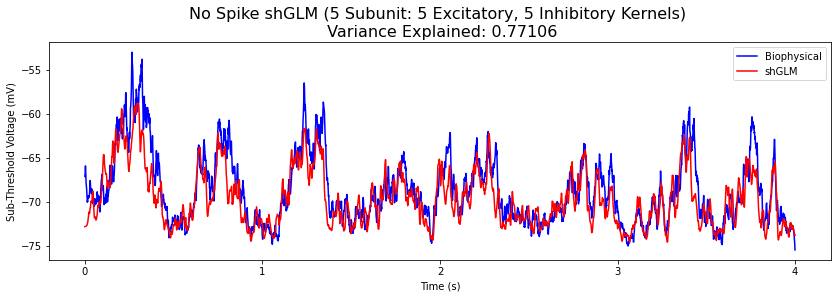

In [6]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[:4000], label="Biophysical", c="blue")
plt.plot(test_V_final[:4000]-1.3, label="shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("No Spike shGLM (5 Subunit: 5 Excitatory, 5 Inhibitory Kernels) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/shglm/biophysical/final5_nospike.png", dpi=150, bbox_inches='tight')

In [7]:
for name, param in final_shGLM.named_parameters():
    if param.requires_grad:
        print(name, param.data)

V_o tensor([-76.0649], device='cuda:0')
K_syn tensor([[[ 0.0186, -0.0238]],

        [[ 0.1814, -0.0141]],

        [[ 0.2150, -0.0691]],

        [[ 0.1416, -0.0721]],

        [[ 0.1848, -0.1480]]], device='cuda:0')
Delta tensor([4.6005], device='cuda:0')
C tensor([3.0235, 0.8632, 0.8776, 1.2156, 0.8883], device='cuda:0')
Theta tensor([3.3843, 0.9971, 1.8942, 1.4188, 1.3132], device='cuda:0')
thresh tensor([85., 85., 85., 85., 85.], device='cuda:0')
spike_size tensor([4., 4., 4., 4., 4.], device='cuda:0')
K_hist tensor([[-0.0250, -0.0250, -0.0250],
        [-0.0250, -0.0250, -0.0250],
        [-0.0250, -0.0250, -0.0250],
        [-0.0250, -0.0250, -0.0250],
        [-0.0250, -0.0250, -0.0250]], device='cuda:0')
